## User Cycle Visualization
The main idea of the notebook is to visualize that users would interact with your product - either a website or a mobile app - according to their own **"cycle"**. 

And you, as a product owner, should try to delicately **choose the right time to interact with your customers** (e.g., sending a notification) according to their cycles respectively, instead of reaching out to them simply according to your own arbitrary time schedules.

This notebook is inspired by [Alexandre Macmillan](https://alexandremacmillan.com/2018/05/19/observe-your-user-cycles-and-design-around-them-not-against-them-2/).

We will use the *MovieLens 10M Dataset* ([Link](https://grouplens.org/datasets/movielens/)) as a user cycle visualization example.

In [1]:
#@title Download MovieLens 10M Dataset
!wget "http://files.grouplens.org/datasets/movielens/ml-10m.zip"
!unzip "ml-10m.zip"
!ls './ml-10M100K'

--2020-09-04 08:06:25--  http://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  99.7MB/s    in 0.6s    

2020-09-04 08:06:26 (99.7 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]

Archive:  ml-10m.zip
   creating: ml-10M100K/
  inflating: ml-10M100K/allbut.pl    
  inflating: ml-10M100K/movies.dat   
  inflating: ml-10M100K/ratings.dat  
  inflating: ml-10M100K/README.html  
  inflating: ml-10M100K/split_ratings.sh  
  inflating: ml-10M100K/tags.dat     
allbut.pl  movies.dat  ratings.dat  README.html  split_ratings.sh  tags.dat


In [2]:
#@title Peek the Top Few Lines of Data
with open('./ml-10M100K/ratings.dat') as f:
    print(f.readline())
    print(f.readline())
    print(f.readline())
    print(f.readline())

1::122::5::838985046

1::185::5::838983525

1::231::5::838983392

1::292::5::838983421



In [3]:
#@title Import Packages
import pandas as pd
from plotnine import *

In [4]:
#@title Load Data
raw_data = pd.read_csv('./ml-10M100K/ratings.dat', names='UserID::MovieID::Rating::Timestamp'.split('::'), sep='::')
print()
print(f'data shape: {raw_data.shape}')
print()
print(raw_data.head(10))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  



data shape: (10000054, 4)

   UserID  MovieID  Rating  Timestamp
0       1      122     5.0  838985046
1       1      185     5.0  838983525
2       1      231     5.0  838983392
3       1      292     5.0  838983421
4       1      316     5.0  838983392
5       1      329     5.0  838983392
6       1      355     5.0  838984474
7       1      356     5.0  838983653
8       1      362     5.0  838984885
9       1      364     5.0  838983707


In [5]:
#@title Preprocess Data: Calulate the "User Cycle"
data = raw_data.assign(Timestamp=lambda x: x['Timestamp'].map(lambda t: pd.Timestamp(t, unit='s')))
data = (data.assign(user_timestamp_min=lambda df: df.groupby('UserID')['Timestamp'].transform(min),
                    hour_diff_from_min=lambda df: (df['Timestamp'] - df['user_timestamp_min']).astype('timedelta64[h]'))
            .query(f'hour_diff_from_min <= {24*30+6}'))
print('Have a look at some of the preprocessed data:\n')
print(data.sample(n=20, random_state=42)[['Timestamp', 'user_timestamp_min', 'hour_diff_from_min']])

Have a look at some of the preprocessed data:

                  Timestamp  user_timestamp_min  hour_diff_from_min
6864224 1996-07-14 01:34:06 1996-07-14 01:21:49                 0.0
7210141 2001-07-17 03:37:39 2001-07-17 03:09:34                 0.0
2577421 2007-01-16 20:32:57 2007-01-16 20:32:03                 0.0
9983815 2004-05-07 15:21:24 2004-05-06 13:28:11                25.0
3731119 2000-03-10 03:38:22 2000-03-10 03:21:04                 0.0
352685  2005-12-16 19:05:24 2005-12-16 18:56:11                 0.0
9987808 2006-10-29 00:51:20 2006-10-29 00:20:16                 0.0
7372700 2005-09-13 05:18:27 2005-09-13 04:59:39                 0.0
2614881 1999-11-24 11:41:18 1999-11-24 11:40:24                 0.0
9486292 2006-10-16 23:05:39 2006-10-11 21:46:44               121.0
9155574 2008-06-08 03:11:45 2008-06-06 19:24:39                31.0
3321852 2001-05-24 21:22:02 2001-05-23 15:49:14                29.0
7385411 2000-12-19 09:51:31 2000-12-19 09:34:45                 0.0
1

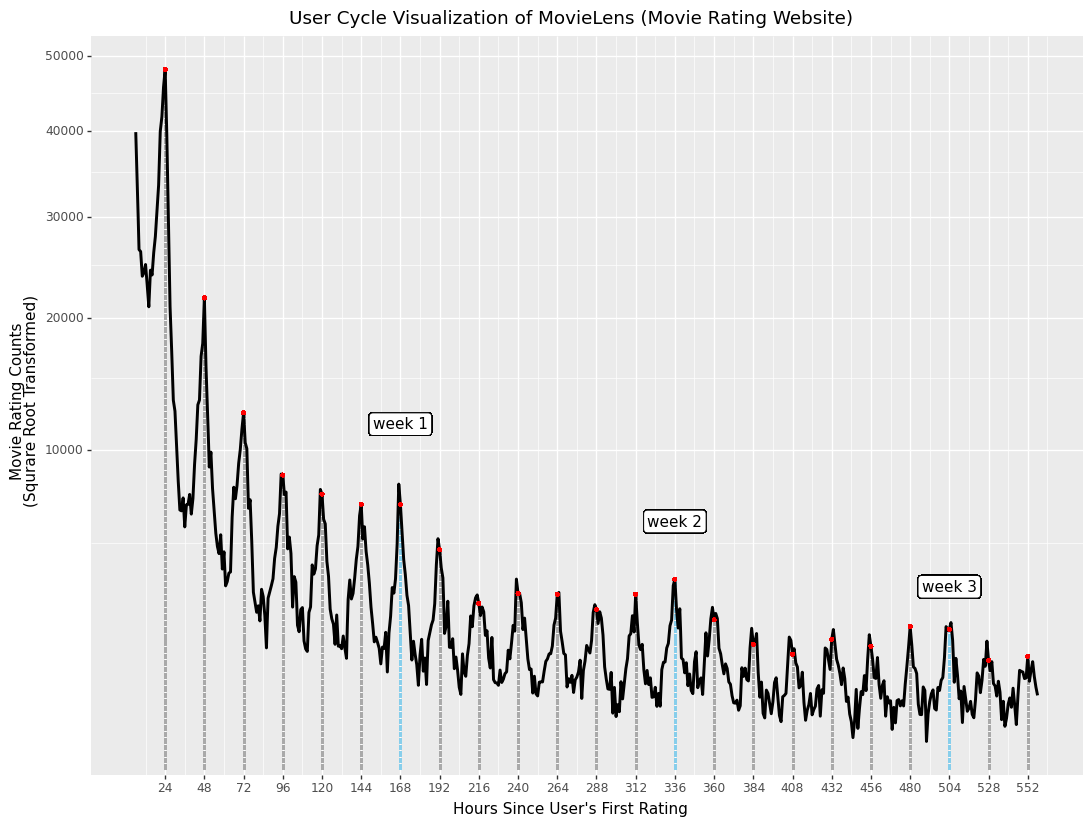

<ggplot: (8783145497250)>


In [6]:
#@title Data Visualization
day_count = 23 # set number of days to be visualized
plot_data = (data.groupby('hour_diff_from_min')
                 .apply(len)
                 .rename('count')
                 .reset_index()
                 .query(f"6 <= hour_diff_from_min <= {day_count*24+6}"))
# print(plot_data.head(10))

# Plotting Layer by Layer Using ggplot
g = (
        ggplot(data=plot_data, mapping=aes('hour_diff_from_min', 'count'))
    )
for i in range(day_count):
    count = plot_data.loc[plot_data['hour_diff_from_min'] == 24*(i+1)]['count'].iloc[0]
    g += geom_segment(x=24*(i+1), xend=24*(i+1), y=0, yend=count, colour='skyblue' if (i+1) % 7 == 0 else 'darkgrey', linetype='dashed', size=0.5)
g += geom_line(size=1.2)
for i in range(day_count):
    count = plot_data.loc[plot_data['hour_diff_from_min'] == 24*(i+1)]['count'].iloc[0]
    g += geom_point(x=24*(i+1), y=count, colour='red', size=0.7)
    if (i+1) % 7 == 0:
        g += geom_label(x=24*(i+1), y=count*1.7, label=f'week {(i+1) // 7}')
g += scale_x_continuous(breaks=[(i+1)*24 for i in range(day_count)])
g += coord_trans(y='sqrt')
g += labs(x='Hours Since User\'s First Rating', y='Movie Rating Counts\n(Squrare Root Transformed)')
g += ggtitle('User Cycle Visualization of MovieLens (Movie Rating Website)')
g += theme(figure_size=(6.4*2, 4.8*2))
print(g)